# 02 Data Exploration

This notebook extends `01_preliminary_data_understanding` to explore:
- Tumor volume vs. voxel count and number of slices spanned
- Slice thickness vs. apparent smoothness
- Reconstruction kernel vs. image texture
- Tumor morphology vs. segmentation-difficulty proxies

Data priority: prefer DICOM (NSCLC-Radiomics) for metadata; fall back to interim NIfTI labels where needed.


In [1]:
# Imports
from __future__ import annotations

import os
from pathlib import Path
from dataclasses import dataclass
from typing import Optional, Dict, Any, List, Tuple

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nibabel as nib
import SimpleITK as sitk

from skimage import measure
from scipy import stats

# Suppress noisy SimpleITK/GDCM series warnings during discovery
try:
    sitk.ProcessObject_SetGlobalWarningDisplay(False)
except Exception:
    pass

# Optional: PyRadiomics
try:
    from radiomics import featureextractor  # type: ignore
    PYRADIOMICS_AVAILABLE = True
except Exception:
    PYRADIOMICS_AVAILABLE = False

# Project utils
import sys
sys.path.append(str(Path.cwd() / 'src'))
from utils.geometry import compute_volume_cm3

sns.set_context('talk')
plt.rcParams['figure.dpi'] = 120


In [2]:
# Paths and output locations (robust to running from notebooks/)

def find_project_root(start: Path) -> Path:
    cur = start.resolve()
    for parent in [cur] + list(cur.parents):
        if (parent / 'pyproject.toml').exists() or (parent / '.git').exists():
            return parent
    return start

PROJECT_ROOT = find_project_root(Path.cwd())
DATA_ROOT = PROJECT_ROOT / 'data'
RAW_DICOM_ROOT = DATA_ROOT / 'raw' / 'NSCLC-Radiomics'
CLINICAL_CSV = DATA_ROOT / 'raw' / 'NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv'
FALLBACK_INTERIM = DATA_ROOT / 'interim' / 'slicer_export_LUNG1-001'

PROCESSED_DIR = DATA_ROOT / 'processed'
FIGURES_DIR = PROJECT_ROOT / 'reports' / 'figures'
METRICS_PARQUET = PROCESSED_DIR / 'roi_metrics.parquet'

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print('Project root:', PROJECT_ROOT)
print('Using RAW_DICOM_ROOT:', RAW_DICOM_ROOT)
print('Fallback interim path:', FALLBACK_INTERIM)


Project root: /Users/kai/workspace/capstone
Using RAW_DICOM_ROOT: /Users/kai/workspace/capstone/data/raw/NSCLC-Radiomics
Fallback interim path: /Users/kai/workspace/capstone/data/interim/slicer_export_LUNG1-001


In [3]:
# Utility functions: IO, metadata, resampling, surfaces, morphology

@dataclass
class SeriesInfo:
    patient_id: str
    series_uid: str
    num_ct_slices: int
    spacing_xyz_mm: Tuple[float, float, float]
    pixel_spacing_xy_mm: Tuple[float, float]
    slice_thickness_mm: Optional[float]
    convolution_kernel: Optional[str]
    manufacturer: Optional[str]
    source_path: Path


def try_read_dicom_series(dir_path: Path) -> Optional[Tuple[sitk.Image, SeriesInfo]]:
    try:
        reader = sitk.ImageSeriesReader()
        # Search subdirectories that actually contain DICOM files
        candidate_dirs: List[str] = []
        for root, _, files in os.walk(dir_path):
            if any(f.lower().endswith('.dcm') for f in files):
                candidate_dirs.append(root)
        if not candidate_dirs:
            return None
        import pydicom
        best_tuple = None  # (series_dir, uid, files, ds)
        best_len = -1
        # Prefer CT modality and the series with most files
        for cand in candidate_dirs:
            try:
                uids = reader.GetGDCMSeriesIDs(cand)
            except Exception:
                continue
            for uid in (uids or []):
                try:
                    files = reader.GetGDCMSeriesFileNames(cand, uid)
                    if not files:
                        continue
                    ds = pydicom.dcmread(files[0], stop_before_pixels=True, force=True)
                    modality = str(getattr(ds, 'Modality', ''))
                    if modality != 'CT':
                        continue
                    if len(files) > best_len:
                        best_tuple = (cand, uid, files, ds)
                        best_len = len(files)
                except Exception:
                    continue
        # Fallback: if no CT series found, take the largest series regardless of modality
        if best_tuple is None:
            for cand in candidate_dirs:
                try:
                    uids = reader.GetGDCMSeriesIDs(cand)
                except Exception:
                    continue
                for uid in (uids or []):
                    try:
                        files = reader.GetGDCMSeriesFileNames(cand, uid)
                        if files and len(files) > best_len:
                            ds = pydicom.dcmread(files[0], stop_before_pixels=True, force=True)
                            best_tuple = (cand, uid, files, ds)
                            best_len = len(files)
                    except Exception:
                        continue
        if best_tuple is None:
            return None
        series_dir, series_uid, file_names, ds = best_tuple
        reader.SetFileNames(file_names)
        image = reader.Execute()
        spacing = tuple(float(s) for s in image.GetSpacing())  # (x, y, z) in SITK
        # Metadata
        slice_thickness = None
        convolution_kernel = None
        manufacturer = None
        ps_xy = (np.nan, np.nan)
        try:
            slice_thickness = float(getattr(ds, 'SliceThickness', None)) if hasattr(ds, 'SliceThickness') else None
        except Exception:
            slice_thickness = None
        try:
            convolution_kernel = str(getattr(ds, 'ConvolutionKernel', None)) if hasattr(ds, 'ConvolutionKernel') else None
        except Exception:
            convolution_kernel = None
        try:
            manufacturer = str(getattr(ds, 'Manufacturer', None)) if hasattr(ds, 'Manufacturer') else None
        except Exception:
            manufacturer = None
        try:
            px = getattr(ds, 'PixelSpacing', None)
            if px is not None and len(px) >= 2:
                ps_xy = (float(px[0]), float(px[1]))
        except Exception:
            ps_xy = (np.nan, np.nan)
        info = SeriesInfo(
            patient_id=dir_path.name,
            series_uid=series_uid,
            num_ct_slices=image.GetSize()[2],
            spacing_xyz_mm=(spacing[0], spacing[1], spacing[2]),
            pixel_spacing_xy_mm=(ps_xy[0], ps_xy[1]),
            slice_thickness_mm=float(slice_thickness) if slice_thickness else None,
            convolution_kernel=convolution_kernel,
            manufacturer=manufacturer,
            source_path=Path(series_dir),
        )
        return image, info
    except Exception:
        return None


def load_nifti(path: Path) -> Tuple[np.ndarray, Tuple[float, float, float]]:
    img = nib.load(str(path))
    data = img.get_fdata()
    header = img.header
    zooms = header.get_zooms()[:3]
    spacing = (float(zooms[0]), float(zooms[1]), float(zooms[2]))
    return np.asarray(data), spacing


def resample_isotropic_sitk(image: sitk.Image, out_spacing=(1.0, 1.0, 1.0), interp=sitk.sitkLinear) -> sitk.Image:
    original_spacing = image.GetSpacing()
    original_size = image.GetSize()
    out_size = [int(round(osz * ospc / nspc)) for osz, ospc, nspc in zip(original_size, original_spacing, out_spacing)]
    resampler = sitk.ResampleImageFilter()
    resampler.SetInterpolator(interp)
    resampler.SetOutputSpacing(out_spacing)
    resampler.SetSize(out_size)
    resampler.SetOutputDirection(image.GetDirection())
    resampler.SetOutputOrigin(image.GetOrigin())
    return resampler.Execute(image)


def resample_mask_to_spacing(mask_np: np.ndarray, spacing: Tuple[float, float, float], out_spacing=(1.0,1.0,1.0)) -> np.ndarray:
    # Use SITK to handle spacing properly
    img = sitk.GetImageFromArray(mask_np.astype(np.uint8))
    img.SetSpacing((spacing[2], spacing[1], spacing[0]))  # array z,y,x => SITK x,y,z
    img_iso = resample_isotropic_sitk(img, out_spacing=(out_spacing[0], out_spacing[1], out_spacing[2]), interp=sitk.sitkNearestNeighbor)
    iso = sitk.GetArrayFromImage(img_iso).astype(bool)
    return iso


def surface_area_and_volume(mask_iso: np.ndarray) -> Tuple[float, float]:
    # mask_iso assumed isotropic 1mm for direct area in mm^2 (approx via marching cubes)
    verts, faces, _, _ = measure.marching_cubes(mask_iso.astype(np.float32), level=0.5)
    # Triangle areas
    tri = verts[faces]
    v1 = tri[:,1] - tri[:,0]
    v2 = tri[:,2] - tri[:,0]
    cross = np.cross(v1, v2)
    areas = np.linalg.norm(cross, axis=1) * 0.5
    surface_area_mm2 = areas.sum()
    volume_mm3 = float(mask_iso.sum())  # 1 mm^3 voxels
    return surface_area_mm2, volume_mm3


def sphericity_from_area_volume(surface_area_mm2: float, volume_mm3: float) -> float:
    if surface_area_mm2 <= 0 or volume_mm3 <= 0:
        return np.nan
    return (np.pi ** (1/3) * (6.0 * volume_mm3) ** (2/3)) / surface_area_mm2


def num_mask_slices(mask_np: np.ndarray) -> int:
    # mask_np as z,y,x array
    z_has = (mask_np.reshape(mask_np.shape[0], -1).sum(axis=1) > 0)
    return int(z_has.sum())


def slice_area_change_index(mask_np: np.ndarray) -> float:
    # mean |Δarea|/area across consecutive z-slices with area>0
    areas = mask_np.reshape(mask_np.shape[0], -1).sum(axis=1).astype(float)
    valid = areas > 0
    idx = np.where(valid)[0]
    if len(idx) < 2:
        return np.nan
    areas_seq = areas[idx]
    diffs = np.abs(np.diff(areas_seq))
    denom = (areas_seq[1:] + 1e-6)
    return float(np.mean(diffs / denom))


def z_roughness(mask_np: np.ndarray) -> float:
    areas = mask_np.reshape(mask_np.shape[0], -1).sum(axis=1).astype(float)
    valid_areas = areas[areas > 0]
    if valid_areas.size < 2:
        return np.nan
    return float(np.std(valid_areas / (valid_areas.mean() + 1e-6)))


def kernel_category(kernel: Optional[str]) -> Optional[str]:
    if kernel is None:
        return None
    k = kernel.upper()
    # Siemens
    if k.startswith('B70') or 'LUNG' in k or 'SHARP' in k:
        return 'Sharp'
    if k.startswith('B50') or 'STANDARD' in k or 'STD' in k:
        return 'Standard'
    if k.startswith('B30') or 'SOFT' in k or 'SMOOTH' in k:
        return 'Smooth'
    # GE/Philips fallback heuristics
    if 'BONE' in k:
        return 'Sharp'
    if 'BODY' in k or 'SOFT' in k:
        return 'Smooth'
    return 'Other'


In [4]:
# Configure PyRadiomics extractor
radiomics_extractor = None
if PYRADIOMICS_AVAILABLE:
    settings = {
        'binWidth': 25,
        'resampledPixelSpacing': [1.0, 1.0, 1.0],
        'interpolator': sitk.sitkBSpline,
        'enableCExtensions': True,
    }
    radiomics_extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
    radiomics_extractor.enableAllFeatures()
    # Reduce radiomics logging noise and avoid shape2D warnings
    import logging
    logging.getLogger('radiomics').setLevel(logging.ERROR)
    try:
        radiomics_extractor.disableFeatureClassByName('shape2D')
    except Exception:
        pass
else:
    print('PyRadiomics not available; texture feature extraction will be skipped.')


In [5]:
# Enhanced discovery: find DICOM SEG masks under patient folders

def find_dicom_seg_mask(patient_dir: Path) -> Optional[Path]:
    for root, _, files in os.walk(patient_dir):
        if 'seg' in root.lower() or 'segment' in root.lower():
            for f in files:
                if f.lower().endswith('.dcm'):
                    return Path(root) / f
    return None


def discover_dicom_patients(root: Path) -> List[Path]:
    if not root.exists():
        return []
    return sorted([p for p in root.iterdir() if p.is_dir() and p.name.startswith('LUNG1-')])


def build_case_index() -> pd.DataFrame:
    rows: List[Dict[str, Any]] = []
    from tqdm import tqdm

    patients = discover_dicom_patients(RAW_DICOM_ROOT)
    for patient_dir in tqdm(patients, desc="Discovering DICOM patients"):
        tried = try_read_dicom_series(patient_dir)
        if not tried:
            continue
        image, info = tried
        seg_path = find_dicom_seg_mask(patient_dir)
        rows.append({
            'patient_id': info.patient_id,
            'series_uid': info.series_uid,
            'num_ct_slices': info.num_ct_slices,
            'slice_thickness_mm': info.slice_thickness_mm,
            'spacing_x_mm': info.spacing_xyz_mm[0],
            'spacing_y_mm': info.spacing_xyz_mm[1],
            'spacing_z_mm': info.spacing_xyz_mm[2],
            'pixel_spacing_x_mm': info.pixel_spacing_xy_mm[0],
            'pixel_spacing_y_mm': info.pixel_spacing_xy_mm[1],
            'convolution_kernel': info.convolution_kernel,
            'kernel_category': kernel_category(info.convolution_kernel),
            'manufacturer': info.manufacturer,
            'source': 'DICOM',
            'ct_path': str(info.source_path),
            'mask_path': str(seg_path) if seg_path else None,
        })
    # Fallback interim example
    ct_nii = FALLBACK_INTERIM / 'ct.nii.gz'
    seg_nii = FALLBACK_INTERIM / 'seg.nii.gz'
    if seg_nii.exists() and ct_nii.exists():
        ct_arr, ct_spacing = load_nifti(ct_nii)
        rows.append({
            'patient_id': 'LUNG1-001',
            'series_uid': 'interim-ct',
            'num_ct_slices': int(ct_arr.shape[2]) if ct_arr.ndim == 3 else int(ct_arr.shape[-1]),
            'slice_thickness_mm': float(ct_spacing[2]),
            'spacing_x_mm': float(ct_spacing[0]),
            'spacing_y_mm': float(ct_spacing[1]),
            'spacing_z_mm': float(ct_spacing[2]),
            'pixel_spacing_x_mm': float(ct_spacing[0]),
            'pixel_spacing_y_mm': float(ct_spacing[1]),
            'convolution_kernel': None,
            'kernel_category': None,
            'manufacturer': None,
            'source': 'NIfTI-interim',
            'ct_path': str(ct_nii),
            'mask_path': str(seg_nii),
        })
    return pd.DataFrame(rows)

case_index = build_case_index()
print('Cases discovered:', len(case_index))
case_index.head(3)


Discovering DICOM patients: 100%|██████████| 422/422 [02:27<00:00,  2.86it/s]

Cases discovered: 423


,patient_id,series_uid,num_ct_slices,slice_thickness_mm,spacing_x_mm,spacing_y_mm,spacing_z_mm,pixel_spacing_x_mm,pixel_spacing_y_mm,convolution_kernel,kernel_category,manufacturer,source,ct_path,mask_path
0,LUNG1-001,1.3.6.1.4.1.32722.99.99.2989917765213423750108...,134,3.0,0.976562,0.976562,3.0,0.976562,0.976562,B19f,Other,SIEMENS,DICOM,/Users/kai/workspace/capstone/data/raw/NSCLC-R...,/Users/kai/workspace/capstone/data/raw/NSCLC-R...
1,LUNG1-002,1.3.6.1.4.1.32722.99.99.2329880015517990803358...,111,3.0,0.977000,0.977000,3.0,0.977000,0.977000,None,None,"CMS, Inc.",DICOM,/Users/kai/workspace/capstone/data/raw/NSCLC-R...,/Users/kai/workspace/capstone/data/raw/NSCLC-R...
2,LUNG1-003,1.3.6.1.4.1.32722.99.99.2389222799296192439904...,107,3.0,0.977000,0.977000,3.0,0.977000,0.977000,None,None,"CMS, Inc.",DICOM,/Users/kai/workspace/capstone/data/raw/NSCLC-R...,/Users/kai/workspace/capstone/data/raw/NSCLC-R...


In [6]:
# Update metrics function to support DICOM SEG masks via SimpleITK
from typing import Union

def load_mask_any(mask_path: Union[str, Path]) -> Tuple[np.ndarray, Tuple[float,float,float]]:
    p = Path(mask_path)
    if p.suffix.lower() in ['.nii', '.gz']:
        data, spacing = load_nifti(p)
        arr_zyx = np.transpose(data, (2,1,0)) if data.ndim == 3 else data
        return arr_zyx.astype(bool), (float(spacing[0]), float(spacing[1]), float(spacing[2]))
    if p.suffix.lower() == '.dcm':
        try:
            img = sitk.ReadImage(str(p))
            arr = sitk.GetArrayFromImage(img)  # z,y,x
            spacing = img.GetSpacing()  # x,y,z
            return (arr > 0), (float(spacing[0]), float(spacing[1]), float(spacing[2]))
        except Exception as e:
            raise RuntimeError(f'Failed to read DICOM SEG at {p}: {e}')
    raise ValueError(f'Unsupported mask format: {p.suffix}')


def compute_roi_metrics_for_case(row: pd.Series) -> Dict[str, Any]:
    result: Dict[str, Any] = {
        'patient_id': row.get('patient_id'),
        'series_uid': row.get('series_uid'),
        'source': row.get('source'),
        'slice_thickness_mm': row.get('slice_thickness_mm', np.nan),
        'spacing_x_mm': row.get('spacing_x_mm', np.nan),
        'spacing_y_mm': row.get('spacing_y_mm', np.nan),
        'spacing_z_mm': row.get('spacing_z_mm', np.nan),
        'convolution_kernel': row.get('convolution_kernel', None),
        'kernel_category': row.get('kernel_category', None),
        'manufacturer': row.get('manufacturer', None),
        'ct_path': row.get('ct_path', None),
        'mask_path': row.get('mask_path', None),
    }

    mask_path_val = result['mask_path']
    if mask_path_val is None or (isinstance(mask_path_val, float) and np.isnan(mask_path_val)):
        result['has_mask'] = False
        return result

    # Load mask and spacing
    mask_zyx, spacing_xyz = load_mask_any(mask_path_val)
    spacing_x, spacing_y, spacing_z = spacing_xyz

    voxel_count = int(mask_zyx.sum())
    n_mask_slices = num_mask_slices(mask_zyx)
    volume_cm3 = compute_volume_cm3(mask_zyx, (spacing_x, spacing_y, spacing_z))

    mask_iso = resample_mask_to_spacing(mask_zyx, (spacing_x, spacing_y, spacing_z), out_spacing=(1.0,1.0,1.0))
    sa_mm2, vol_iso_mm3 = surface_area_and_volume(mask_iso)
    sphericity = sphericity_from_area_volume(sa_mm2, vol_iso_mm3)
    sv_ratio = sa_mm2 / (vol_iso_mm3 + 1e-6)
    sliceraci = slice_area_change_index(mask_zyx)
    zrough = z_roughness(mask_zyx)

    result.update({
        'has_mask': True,
        'voxel_count': voxel_count,
        'num_mask_slices': n_mask_slices,
        'volume_cm3': volume_cm3,
        'surface_area_mm2_iso': float(sa_mm2),
        'volume_mm3_iso': float(vol_iso_mm3),
        'sphericity_iso': float(sphericity),
        'surface_to_volume_iso': float(sv_ratio),
        'slice_area_change_index': float(sliceraci) if not np.isnan(sliceraci) else np.nan,
        'z_roughness': float(zrough) if not np.isnan(zrough) else np.nan,
    })

    # Radiomics: support NIfTI CT and DICOM CT series
    if PYRADIOMICS_AVAILABLE and radiomics_extractor is not None:
        try:
            ct_path_val = result.get('ct_path')
            roi_ct_sitk = None
            if isinstance(ct_path_val, str) and (ct_path_val.endswith('.nii') or ct_path_val.endswith('.nii.gz')):
                ct_np, ct_spacing = load_nifti(Path(ct_path_val))
                ct_zyx = np.transpose(ct_np, (2,1,0)) if ct_np.ndim == 3 else ct_np
                img = sitk.GetImageFromArray(ct_zyx.astype(np.float32))
                img.SetSpacing((ct_spacing[2], ct_spacing[1], ct_spacing[0]))
                roi_ct_sitk = resample_isotropic_sitk(img, out_spacing=(1.0,1.0,1.0), interp=sitk.sitkBSpline)
            elif isinstance(ct_path_val, str) and Path(ct_path_val).is_dir():
                reader = sitk.ImageSeriesReader()
                uids = reader.GetGDCMSeriesIDs(ct_path_val)
                if uids:
                    files = reader.GetGDCMSeriesFileNames(ct_path_val, uids[0])
                    reader.SetFileNames(files)
                    ct_img = reader.Execute()
                    roi_ct_sitk = resample_isotropic_sitk(ct_img, out_spacing=(1.0,1.0,1.0), interp=sitk.sitkBSpline)
            if roi_ct_sitk is not None:
                mask_sitk = sitk.GetImageFromArray(mask_iso.astype(np.uint8))
                mask_sitk.SetSpacing((1.0,1.0,1.0))
                if list(mask_sitk.GetSize()) != list(roi_ct_sitk.GetSize()):
                    ref = sitk.Image(roi_ct_sitk)
                    mask_sitk = sitk.Resample(mask_sitk, ref, sitk.Transform(), sitk.sitkNearestNeighbor, 0, sitk.sitkUInt8)
                feats: Dict[str, Any] = radiomics_extractor.execute(roi_ct_sitk, mask_sitk)
                for k, v in feats.items():
                    if isinstance(v, (int, float, np.floating)):
                        result[f'radiomics_{k}'] = float(v)
            else:
                result['radiomics_skipped'] = True
        except Exception as e:
            result['radiomics_error'] = str(e)
    else:
        result['radiomics_skipped'] = True

    return result


In [7]:
# Quick diagnostics: print first few patient dirs and whether a series is found
print('RAW_DICOM_ROOT exists:', RAW_DICOM_ROOT.exists())
pts = discover_dicom_patients(RAW_DICOM_ROOT)
print('Found patient dirs:', len(pts))
for pt in pts[:3]:
    tried = try_read_dicom_series(pt)
    print(pt.name, '->', 'OK' if tried else 'no series')


RAW_DICOM_ROOT exists: True
Found patient dirs: 422
LUNG1-001 -> OK
LUNG1-002 -> OK
LUNG1-003 -> OK


In [8]:
# Compute per-case metrics table
if len(case_index) == 0:
    print('No cases discovered. Ensure data is available under', RAW_DICOM_ROOT)
metrics_rows: List[Dict[str, Any]] = []
from tqdm import tqdm
import time

start_time = time.time()
total_cases = len(case_index)
with tqdm(total=total_cases, desc="Computing metrics", unit="case") as pbar:
    for _, r in case_index.iterrows():
        iter_start = time.time()
        row_metrics = compute_roi_metrics_for_case(r)
        metrics_rows.append(row_metrics)
        pbar.update(1)
        elapsed = time.time() - start_time
        cases_done = pbar.n
        # Compute ETA
        if cases_done > 0:
            time_per_case = elapsed / cases_done
            eta = (total_cases - cases_done) * time_per_case
            pbar.set_postfix({
                "Elapsed": f"{int(elapsed//60):02d}:{int(elapsed%60):02d}",
                "ETA": f"{int(eta//60):02d}:{int(eta%60):02d}"
            })
metrics_df = pd.DataFrame(metrics_rows)
metrics_df.head(5)


Computing metrics: 100%|██████████| 423/423 [43:40<00:00,  6.19s/case, Elapsed=43:40, ETA=00:00]


,patient_id,series_uid,source,slice_thickness_mm,spacing_x_mm,spacing_y_mm,spacing_z_mm,convolution_kernel,kernel_category,manufacturer,...,radiomics_diagnostics_Mask-interpolated_VolumeNum,radiomics_diagnostics_Mask-interpolated_Mean,radiomics_diagnostics_Mask-interpolated_Minimum,radiomics_diagnostics_Mask-interpolated_Maximum,radiomics_original_shape_Elongation,radiomics_original_shape_Flatness,radiomics_original_shape_LeastAxisLength,radiomics_original_shape_MajorAxisLength,radiomics_original_shape_MinorAxisLength,radiomics_original_shape_VoxelVolume
0,LUNG1-001,1.3.6.1.4.1.32722.99.99.2989917765213423750108...,DICOM,3.0,0.976562,0.976562,3.0,B19f,Other,SIEMENS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LUNG1-002,1.3.6.1.4.1.32722.99.99.2329880015517990803358...,DICOM,3.0,0.977000,0.977000,3.0,None,None,"CMS, Inc.",...,2.0,-1023.729692,-1024.0,-1023.0,0.295732,0.280599,20.809914,74.162511,21.932260,19918.0
2,LUNG1-003,1.3.6.1.4.1.32722.99.99.2389222799296192439904...,DICOM,3.0,0.977000,0.977000,3.0,None,None,"CMS, Inc.",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LUNG1-004,1.3.6.1.4.1.32722.99.99.2809816144625926346520...,DICOM,3.0,0.976562,0.976562,3.0,B31s,Other,SIEMENS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LUNG1-005,1.3.6.1.4.1.32722.99.99.3490584753983772067630...,DICOM,3.0,0.977000,0.977000,3.0,None,None,"CMS, Inc.",...,2.0,-1023.714198,-1024.0,-1023.0,0.541696,0.250203,18.826239,75.243777,40.759283,6550.0


In [9]:
# Save outputs
try:
    metrics_df.to_parquet(METRICS_PARQUET, index=False)
    print('Saved metrics to', METRICS_PARQUET.resolve())
except Exception as e:
    print('Failed to save parquet:', e)

# # Example: save a figure from volume vs voxel_count
# try:
#     fig_path = FIGURES_DIR / 'volume_vs_voxels.png'
#     fig, ax = plt.subplots(figsize=(6,5))
#     if len(mask_cases) > 0:
#         sns.regplot(data=mask_cases, x='voxel_count', y='volume_cm3', ax=ax)
#         ax.set_title('Volume (cm^3) vs Voxel Count')
#         fig.tight_layout()
#         fig.savefig(fig_path, dpi=150)
#         plt.close(fig)
#         print('Saved figure to', fig_path.resolve())
#     else:
#         print('No mask cases to save volume/voxels figure.')
# except Exception as e:
#     print('Failed to save figure:', e)


Saved metrics to /Users/kai/workspace/capstone/data/processed/roi_metrics.parquet


Slice thickness is constant at 3.00 mm across 422 cases; skipping correlation tests. Showing distributions instead.


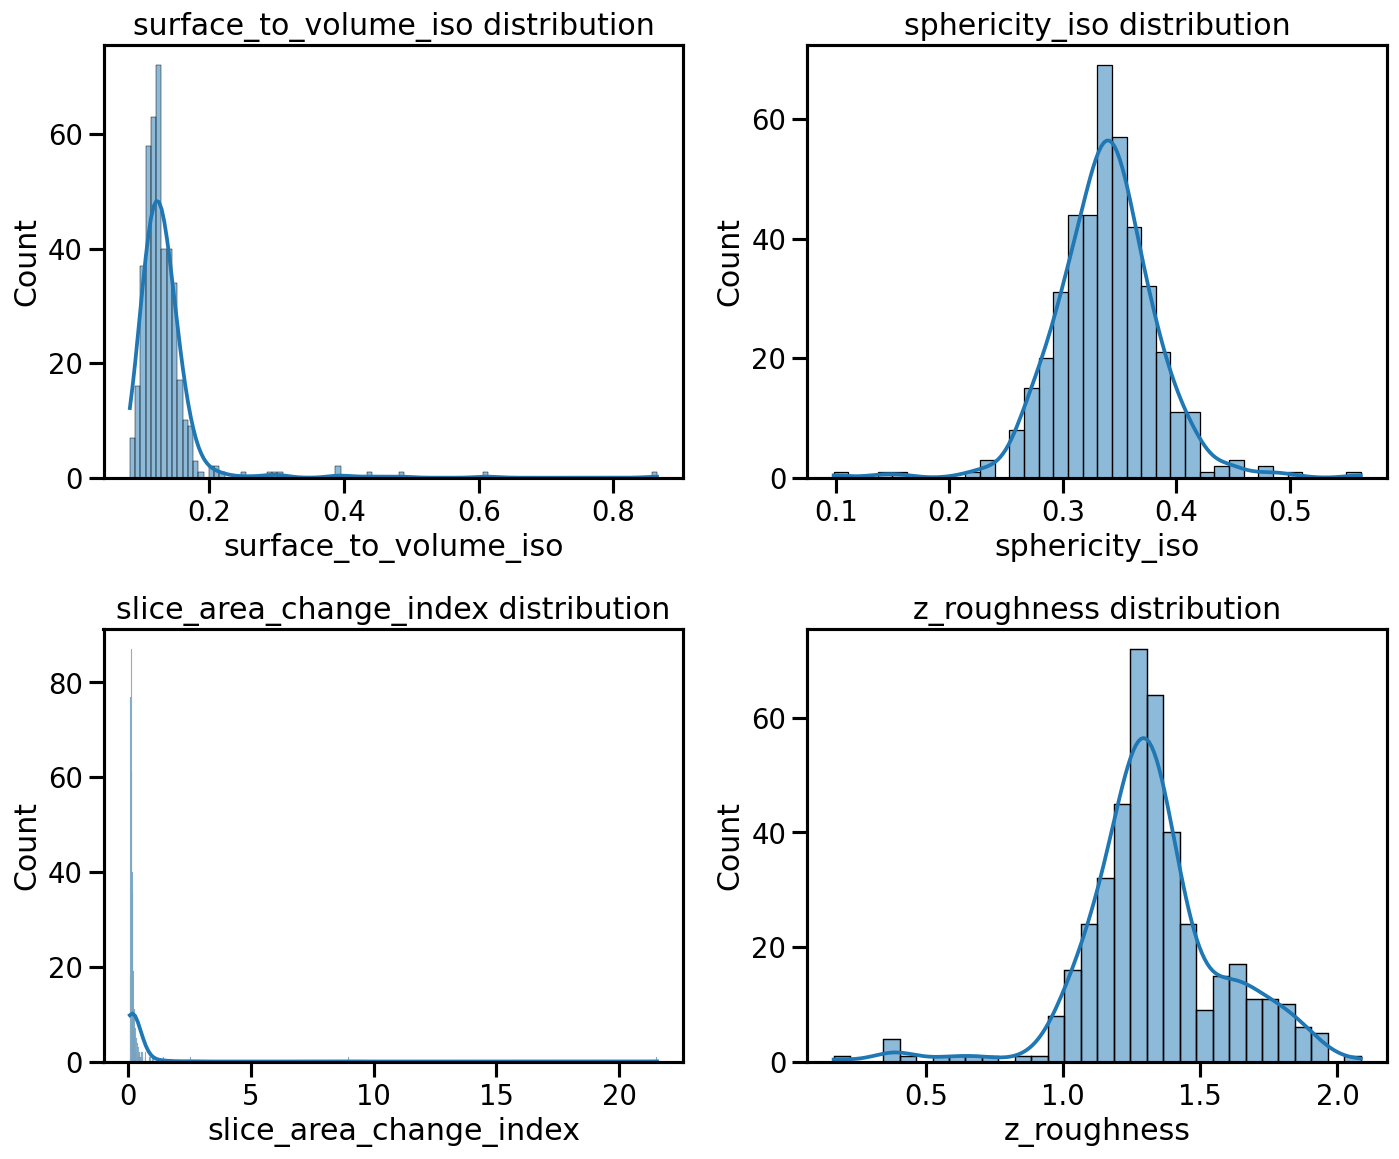

In [10]:
# Slice thickness vs apparent surface smoothness (stair-step effect) with constant-input guard
if 'has_mask' in metrics_df.columns and metrics_df['has_mask'].any():
    plot_df = metrics_df.query('has_mask == True').copy()
    thickness = plot_df['slice_thickness_mm'].dropna()
    unique_thicks = thickness.nunique()
    metrics_list = ['surface_to_volume_iso', 'sphericity_iso', 'slice_area_change_index', 'z_roughness']

    if unique_thicks <= 1:
        val = float(thickness.iloc[0]) if len(thickness) else float('nan')
        print(f'Slice thickness is constant at {val:.2f} mm across {len(thickness)} cases; skipping correlation tests. Showing distributions instead.')
        fig, axes = plt.subplots(2, 2, figsize=(12,10))
        for ax, metric in zip(axes.ravel(), metrics_list):
            if metric in plot_df.columns:
                sns.histplot(data=plot_df, x=metric, ax=ax, kde=True)
                ax.set_title(f'{metric} distribution')
            else:
                ax.text(0.5, 0.5, f'{metric} missing', ha='center')
        plt.tight_layout(); plt.show()
    else:
        for metric in metrics_list:
            if metric in plot_df.columns and plot_df[metric].notna().sum() > 2 and thickness.size > 2:
                rho, p = stats.spearmanr(plot_df['slice_thickness_mm'], plot_df[metric], nan_policy='omit')
                print(f'Spearman thickness vs {metric}: rho={rho:.3f}, p={p:.3g}')
        fig, axes = plt.subplots(2, 2, figsize=(12,10))
        pairs = [
            ('slice_thickness_mm', 'surface_to_volume_iso', 'S/V vs Thickness'),
            ('slice_thickness_mm', 'sphericity_iso', 'Sphericity vs Thickness'),
            ('slice_thickness_mm', 'slice_area_change_index', 'Slice Area Change vs Thickness'),
            ('slice_thickness_mm', 'z_roughness', 'Z-Roughness vs Thickness'),
        ]
        for ax, (x, y, title) in zip(axes.ravel(), pairs):
            if x in plot_df.columns and y in plot_df.columns:
                sns.regplot(data=plot_df, x=x, y=y, ax=ax, scatter_kws={'alpha':0.7})
                ax.set_title(title)
        plt.tight_layout(); plt.show()
else:
    print('No mask-bearing cases available for smoothness analysis.')


Pearson volume vs voxel_count: r=0.993, p=0
Spearman volume vs num_mask_slices: rho=0.374, p=1.71e-15


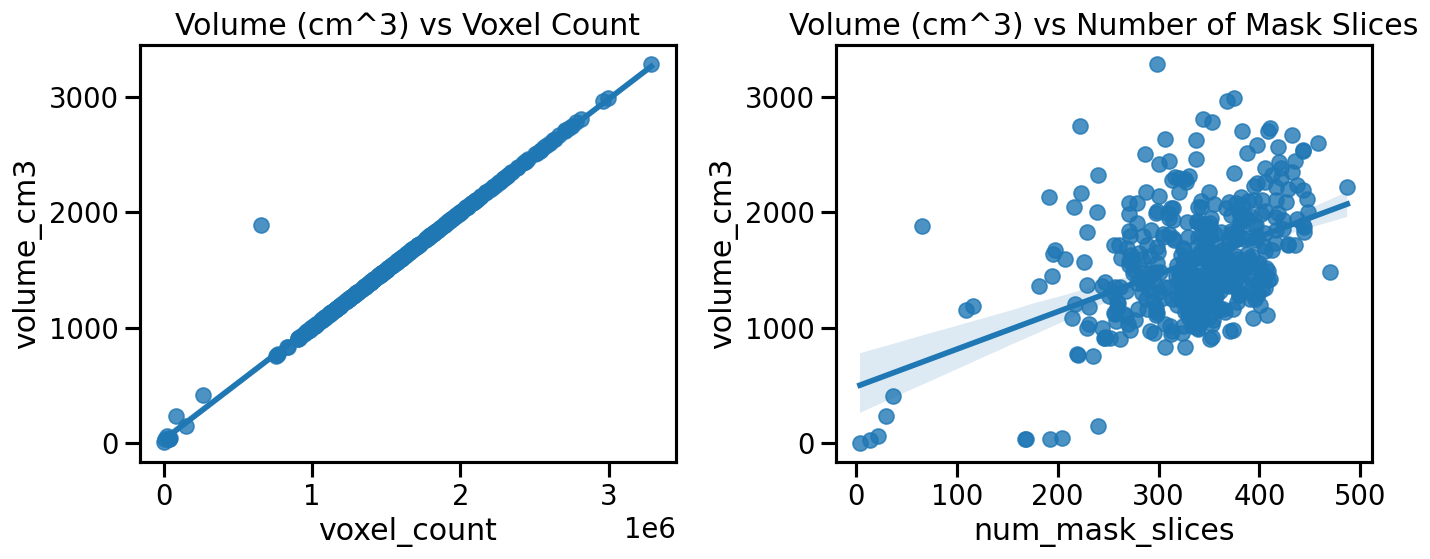

In [11]:
# Volume vs voxel_count and number of slices spanned
mask_cases = metrics_df.query('has_mask == True')

if len(mask_cases) > 0:
    # Correlations
    r1, p1 = stats.pearsonr(mask_cases['volume_cm3'], mask_cases['voxel_count']) if mask_cases['voxel_count'].nunique() > 1 else (np.nan, np.nan)
    r2, p2 = stats.spearmanr(mask_cases['volume_cm3'], mask_cases['num_mask_slices']) if mask_cases['num_mask_slices'].nunique() > 1 else (np.nan, np.nan)
    print(f'Pearson volume vs voxel_count: r={r1:.3f}, p={p1:.3g}')
    print(f'Spearman volume vs num_mask_slices: rho={r2:.3f}, p={p2:.3g}')

    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    sns.regplot(data=mask_cases, x='voxel_count', y='volume_cm3', ax=axes[0])
    axes[0].set_title('Volume (cm^3) vs Voxel Count')
    sns.regplot(data=mask_cases, x='num_mask_slices', y='volume_cm3', ax=axes[1])
    axes[1].set_title('Volume (cm^3) vs Number of Mask Slices')
    plt.tight_layout()
    plt.show()
else:
    print('No mask-bearing cases available for volume analysis.')


In [13]:
# Reconstruction kernel vs texture features (PyRadiomics)
if len(mask_cases) > 0 and PYRADIOMICS_AVAILABLE and radiomics_extractor is not None:
    # Select a few representative texture features if present
    radiomics_cols = [c for c in metrics_df.columns if c.startswith('radiomics_')]
    # PyRadiomics keys usually look like radiomics_original_glcm_Contrast, etc.
    matchers = [
        ('glcm', 'Contrast'),
        ('glcm', 'JointEntropy'),
        ('firstorder', 'Mean'),
        ('firstorder', 'RootMeanSquared'),
        ('glrlm', 'GrayLevelNonUniformity'),
        ('glszm', 'ZoneEntropy'),
    ]
    chosen = [c for c in radiomics_cols if any(m0 in c and m1 in c for m0, m1 in matchers)]
    if len(chosen) == 0:
        print('No radiomics features extracted; check extractor and inputs.')
    else:
        feat_df = mask_cases[['kernel_category'] + chosen].dropna(subset=['kernel_category'])
        if len(feat_df) >= 3 and feat_df['kernel_category'].nunique() > 1:
            for col in chosen:
                plt.figure(figsize=(5,4))
                sns.violinplot(data=feat_df, x='kernel_category', y=col, inner='box')
                plt.title(f'{col} by Kernel Category')
                plt.tight_layout(); plt.show()
            # Kruskal–Wallis across categories (example for the first chosen feature)
            col = chosen[0]
            groups = [g[col].dropna().values for _, g in feat_df.groupby('kernel_category')]
            if all(len(g) > 1 for g in groups) and len(groups) > 1:
                H, p = stats.kruskal(*groups)
                print(f'Kruskal–Wallis for {col}: H={H:.2f}, p={p:.3g}')
        else:
            print('Insufficient kernel category variation for group comparison.')
else:
    print('Kernel analysis skipped (no masks, or radiomics unavailable).')


No radiomics features extracted; check extractor and inputs.


Volume vs surface_to_volume_iso: rho=-0.713, p=7.74e-67 (higher_is_harder)
Volume vs sphericity_iso: rho=0.194, p=6.24e-05 (lower_is_harder)
Volume vs z_roughness: rho=-0.011, p=0.823 (higher_is_harder)
Volume vs slice_area_change_index: rho=0.108, p=0.0264 (higher_is_harder)


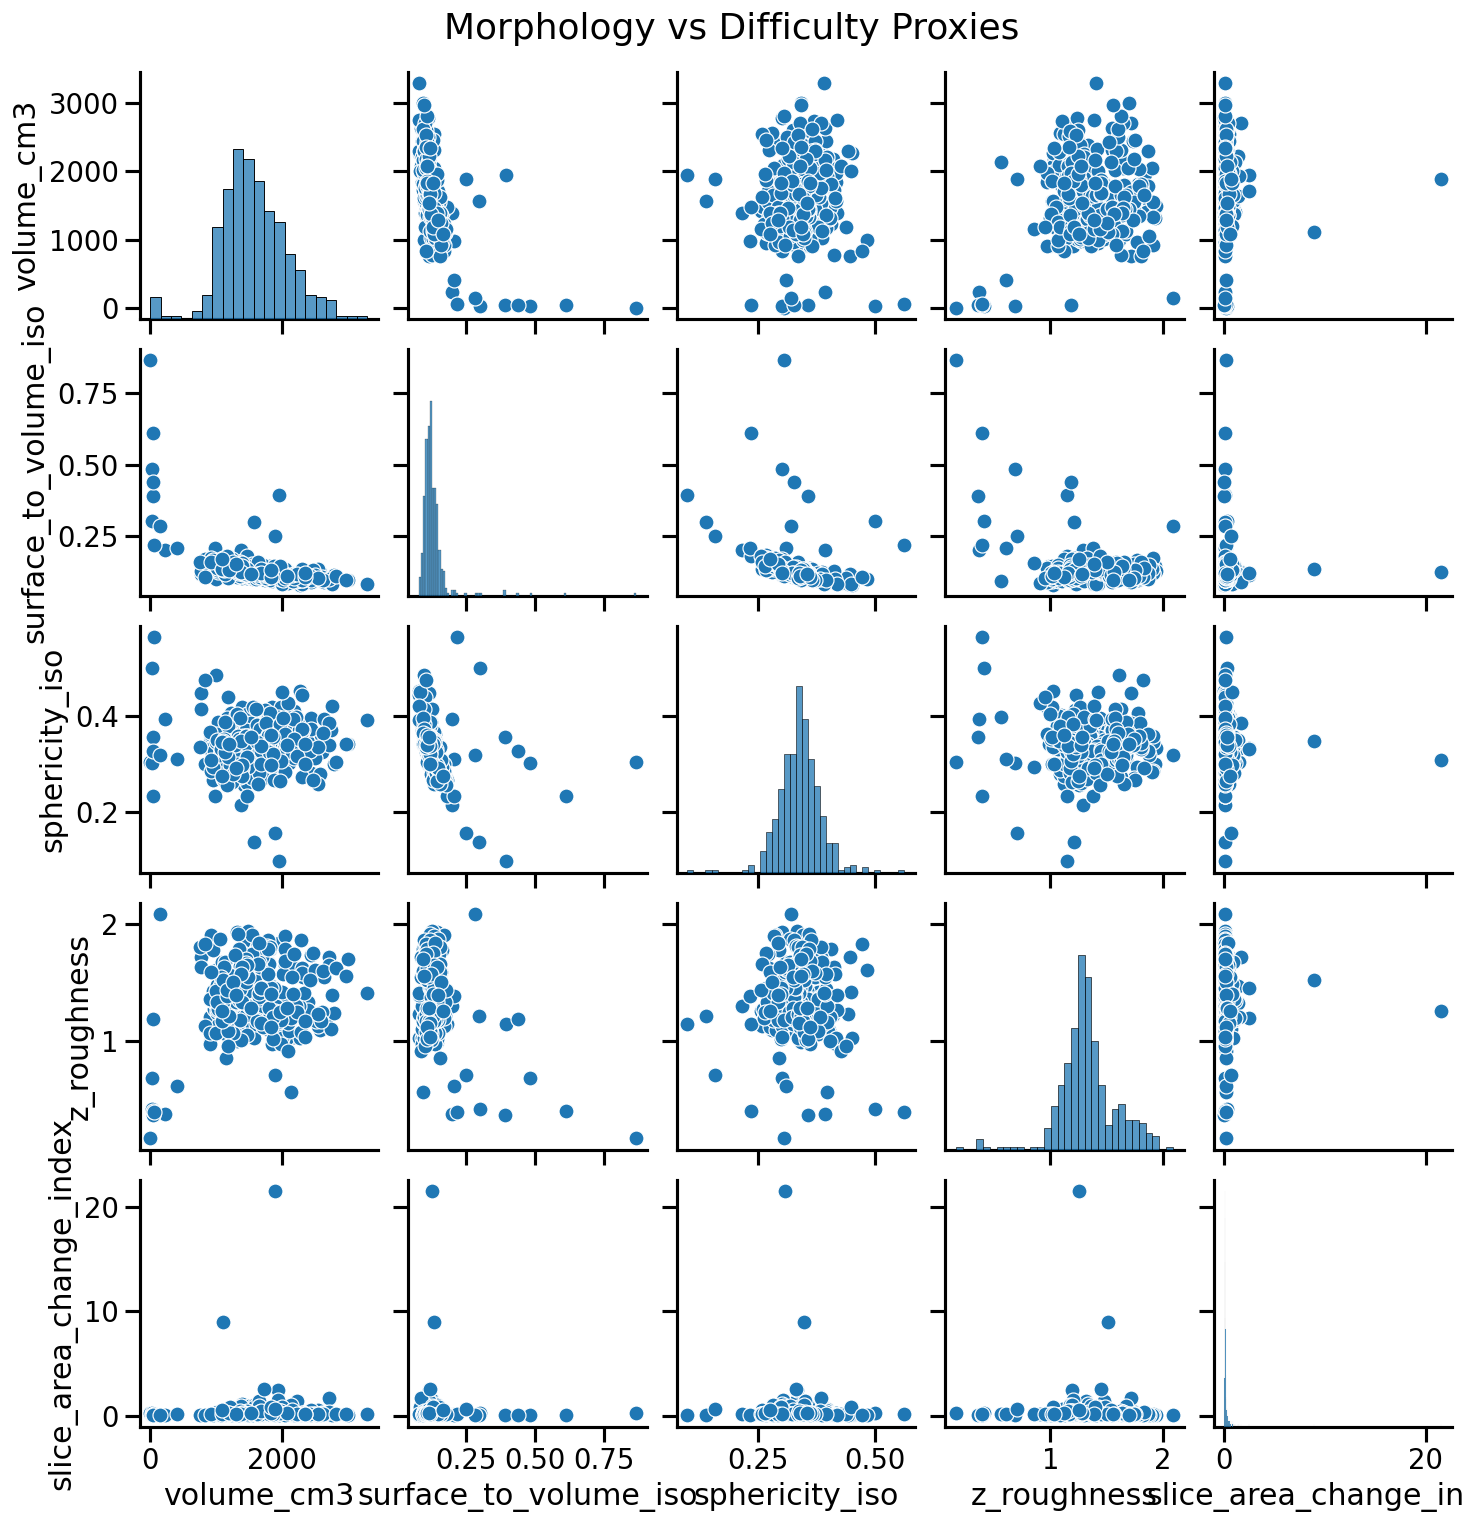

In [14]:
# Morphology vs segmentation-difficulty proxies
if len(mask_cases) > 0:
    morph_df = mask_cases.copy()
    # Proxies for difficulty: higher surface_to_volume, lower sphericity, higher z_roughness, higher slice area change
    difficulty_proxies = {
        'surface_to_volume_iso': 'higher_is_harder',
        'sphericity_iso': 'lower_is_harder',
        'z_roughness': 'higher_is_harder',
        'slice_area_change_index': 'higher_is_harder',
    }
    for feature, direction in difficulty_proxies.items():
        if morph_df[feature].notna().sum() > 3:
            rho, p = stats.spearmanr(morph_df['volume_cm3'], morph_df[feature], nan_policy='omit')
            print(f'Volume vs {feature}: rho={rho:.3f}, p={p:.3g} ({direction})')

    # Pair plots (subset) for visualization
    cols = ['volume_cm3', 'surface_to_volume_iso', 'sphericity_iso', 'z_roughness', 'slice_area_change_index']
    sns.pairplot(morph_df[cols].dropna())
    plt.suptitle('Morphology vs Difficulty Proxies', y=1.02)
    plt.show()
else:
    print('No mask-bearing cases available for morphology/difficulty analysis.')


Overlay generation failed: index 321 is out of bounds for axis 0 with size 134


<Figure size 720x720 with 0 Axes>

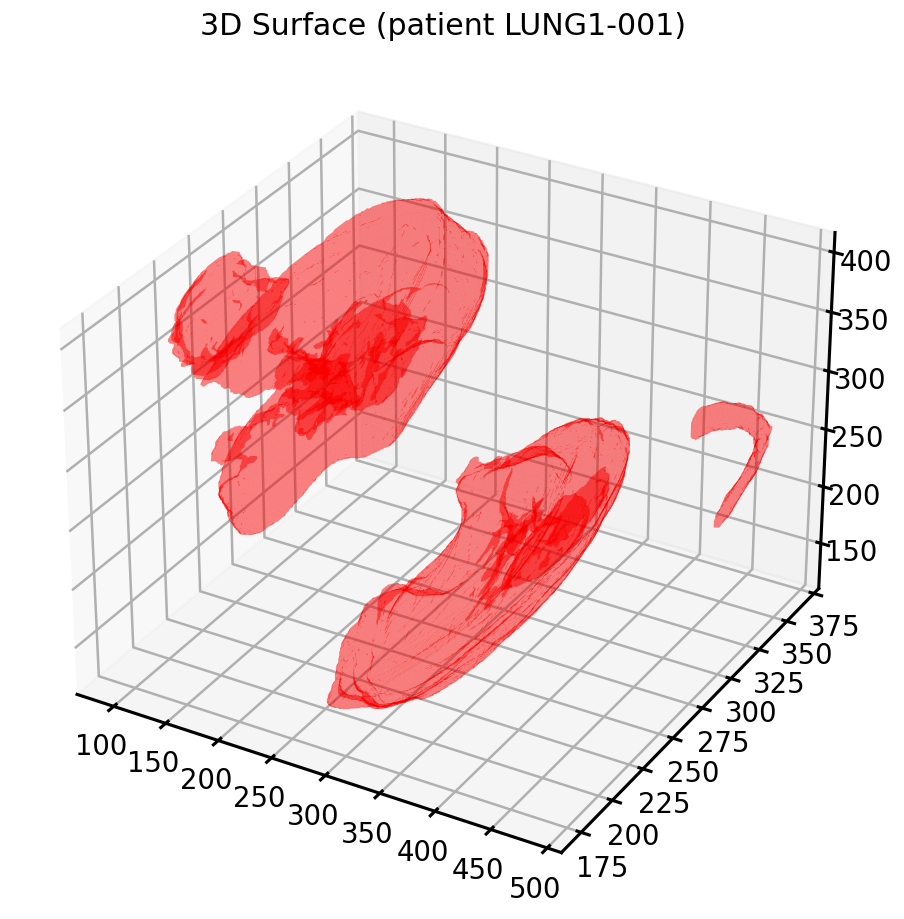

In [15]:
# Visual examples (overlays / 3D surface snapshots)
from matplotlib.patches import Rectangle

# Try to generate an overlay for the first mask case
if 'has_mask' in metrics_df.columns and metrics_df['has_mask'].any():
    row = metrics_df.query('has_mask == True').iloc[0]
    pid = row['patient_id']
    ct_path = Path(row['ct_path']) if isinstance(row.get('ct_path'), str) else None
    mask_path = Path(row['mask_path']) if isinstance(row.get('mask_path'), str) else None
    overlay_out = FIGURES_DIR / 'overlays'
    overlay_out.mkdir(parents=True, exist_ok=True)
    overlay_png = overlay_out / f'{pid}_overlay.png'

    try:
        if ct_path and ct_path.is_dir() and mask_path and mask_path.exists():
            # Read CT DICOM series and mask
            reader = sitk.ImageSeriesReader()
            uids = reader.GetGDCMSeriesIDs(str(ct_path))
            if uids:
                files = reader.GetGDCMSeriesFileNames(str(ct_path), uids[0])
                reader.SetFileNames(files)
                ct_img = reader.Execute()
                ct_arr = sitk.GetArrayFromImage(ct_img)  # z,y,x
                mask_zyx, spacing_xyz = load_mask_any(mask_path)
                # Choose middle slice where mask exists
                z_any = np.where(mask_zyx.reshape(mask_zyx.shape[0], -1).sum(axis=1) > 0)[0]
                if len(z_any) > 0:
                    z = int(np.median(z_any))
                else:
                    z = mask_zyx.shape[0] // 2
                plt.figure(figsize=(6,6))
                plt.imshow(ct_arr[z], cmap='gray')
                plt.imshow(np.ma.masked_where(~mask_zyx[z], mask_zyx[z]), alpha=0.4, cmap='autumn')
                plt.axis('off'); plt.title(f'{pid} overlay (z={z})')
                plt.tight_layout(); plt.savefig(overlay_png, dpi=150)
                plt.show()
                print('Saved overlay to', overlay_png)
            else:
                print('No CT series IDs found for', ct_path)
        else:
            print('CT path or mask path not available; skipping overlay generation.')
    except Exception as e:
        print('Overlay generation failed:', e)
else:
    print('No mask cases to generate overlay.')

# 3D surface render using DICOM-SEG via load_mask_any
if 'has_mask' in metrics_df.columns and metrics_df['has_mask'].any():
    row = metrics_df.query('has_mask == True').iloc[0]
    mask_path = Path(row['mask_path']) if isinstance(row['mask_path'], str) else None
    if mask_path and mask_path.exists():
        mask_zyx, spacing_xyz = load_mask_any(mask_path)
        mask_iso = resample_mask_to_spacing(mask_zyx.astype(bool), spacing_xyz, out_spacing=(1.0,1.0,1.0))
        verts, faces, _, _ = measure.marching_cubes(mask_iso.astype(np.float32), level=0.5)
        from mpl_toolkits.mplot3d.art3d import Poly3DCollection
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111, projection='3d')
        mesh = Poly3DCollection(verts[faces], alpha=0.3)
        mesh.set_facecolor('red')
        ax.add_collection3d(mesh)
        ax.set_xlim(verts[:,0].min(), verts[:,0].max())
        ax.set_ylim(verts[:,1].min(), verts[:,1].max())
        ax.set_zlim(verts[:,2].min(), verts[:,2].max())
        ax.set_title(f'3D Surface (patient {row["patient_id"]})')
        plt.tight_layout(); plt.show()
    else:
        print('No mask file available for 3D surface example.')
else:
    print('No cases with mask for visualization.')


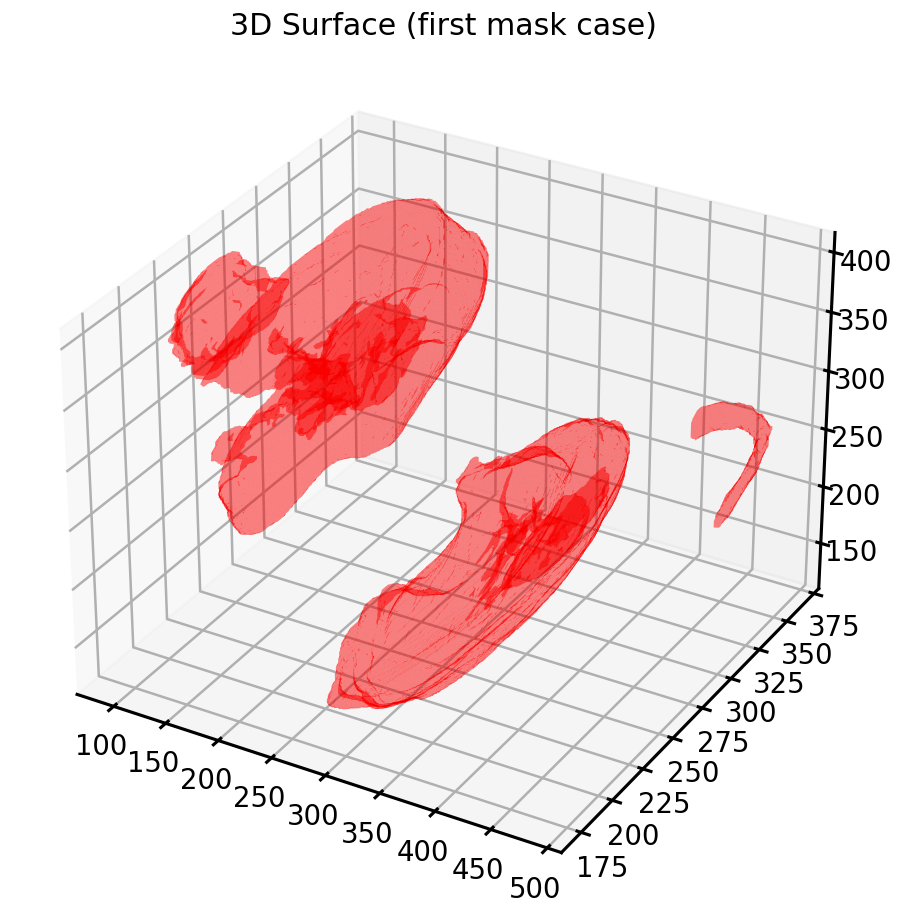

In [16]:
# Safer visual example cell (skips if no mask_path available)
mask_cases = metrics_df.query('has_mask == True') if 'has_mask' in metrics_df.columns else pd.DataFrame()
if len(mask_cases) > 0 and 'mask_path' in mask_cases.columns:
    series = mask_cases['mask_path'].dropna().astype(str)
    if len(series) > 0:
        mask_path = Path(series.iloc[0])
        if mask_path.exists():
            mask_zyx, spacing_xyz = load_mask_any(mask_path)
            mask_iso = resample_mask_to_spacing(mask_zyx.astype(bool), spacing_xyz, out_spacing=(1.0,1.0,1.0))
            from skimage import measure
            verts, faces, _, _ = measure.marching_cubes(mask_iso.astype(np.float32), level=0.5)
            from mpl_toolkits.mplot3d.art3d import Poly3DCollection
            fig = plt.figure(figsize=(8,8))
            ax = fig.add_subplot(111, projection='3d')
            mesh = Poly3DCollection(verts[faces], alpha=0.3)
            mesh.set_facecolor('red')
            ax.add_collection3d(mesh)
            ax.set_xlim(verts[:,0].min(), verts[:,0].max())
            ax.set_ylim(verts[:,1].min(), verts[:,1].max())
            ax.set_zlim(verts[:,2].min(), verts[:,2].max())
            ax.set_title('3D Surface (first mask case)')
            plt.tight_layout(); plt.show()
        else:
            print('First mask_path does not exist on disk:', mask_path)
    else:
        print('No non-null mask_path values; skipping 3D surface example.')
else:
    print('No mask cases or mask_path column missing; skipping 3D surface example.')
